In [1]:
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn import metrics
import numpy as np



  ### Preprocessing

In [2]:
# Load data
import yfinance as yf

btcdata = yf.download("ETH-USD", start="2020-04-01", end="2022-04-07")
df = pd.DataFrame(btcdata)
df.drop(columns=['Adj Close'],inplace=True)

df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-04-01,133.612320,135.634552,129.730942,135.634552,12456564435
2020-04-02,135.732178,146.787094,135.732178,142.029144,15322861686
2020-04-03,142.110458,146.899872,139.619385,142.091309,13184603402
2020-04-04,142.215179,145.377304,140.121826,145.219391,11946658257
2020-04-05,145.261017,146.128525,142.102081,143.546646,11280993591
...,...,...,...,...,...
2022-04-03,3444.810547,3573.960205,3421.259766,3522.833496,15333808649
2022-04-04,3522.364990,3535.148193,3422.000977,3521.241211,18209969743
2022-04-05,3521.239746,3546.706787,3410.547607,3411.792480,16681503199


###### Shift the data so that we can use the old data to predict future close pricing

In [3]:
# Define features set
df['Open']=df.Open.shift(-1)
df['High']=df.High.shift(-1)
df['Low']=df.Low.shift(-1)
df['Volume']=df.Low.shift(-1)
df.dropna(inplace=True)
X=df.copy()
X.drop("Close", axis=1, inplace=True)
X

,Open,High,Low,Volume
Date,,,,
2020-04-01,135.732178,146.787094,135.732178,139.619385
2020-04-02,142.110458,146.899872,139.619385,140.121826
2020-04-03,142.215179,145.377304,140.121826,142.102081
2020-04-04,145.261017,146.128525,142.102081,143.544601
2020-04-05,143.608215,169.272644,143.544601,164.203323
...,...,...,...,...
2022-04-01,3449.788574,3521.284668,3442.000244,3421.259766
2022-04-02,3444.810547,3573.960205,3421.259766,3422.000977
2022-04-03,3522.364990,3535.148193,3422.000977,3410.547607


<AxesSubplot:xlabel='Date'>

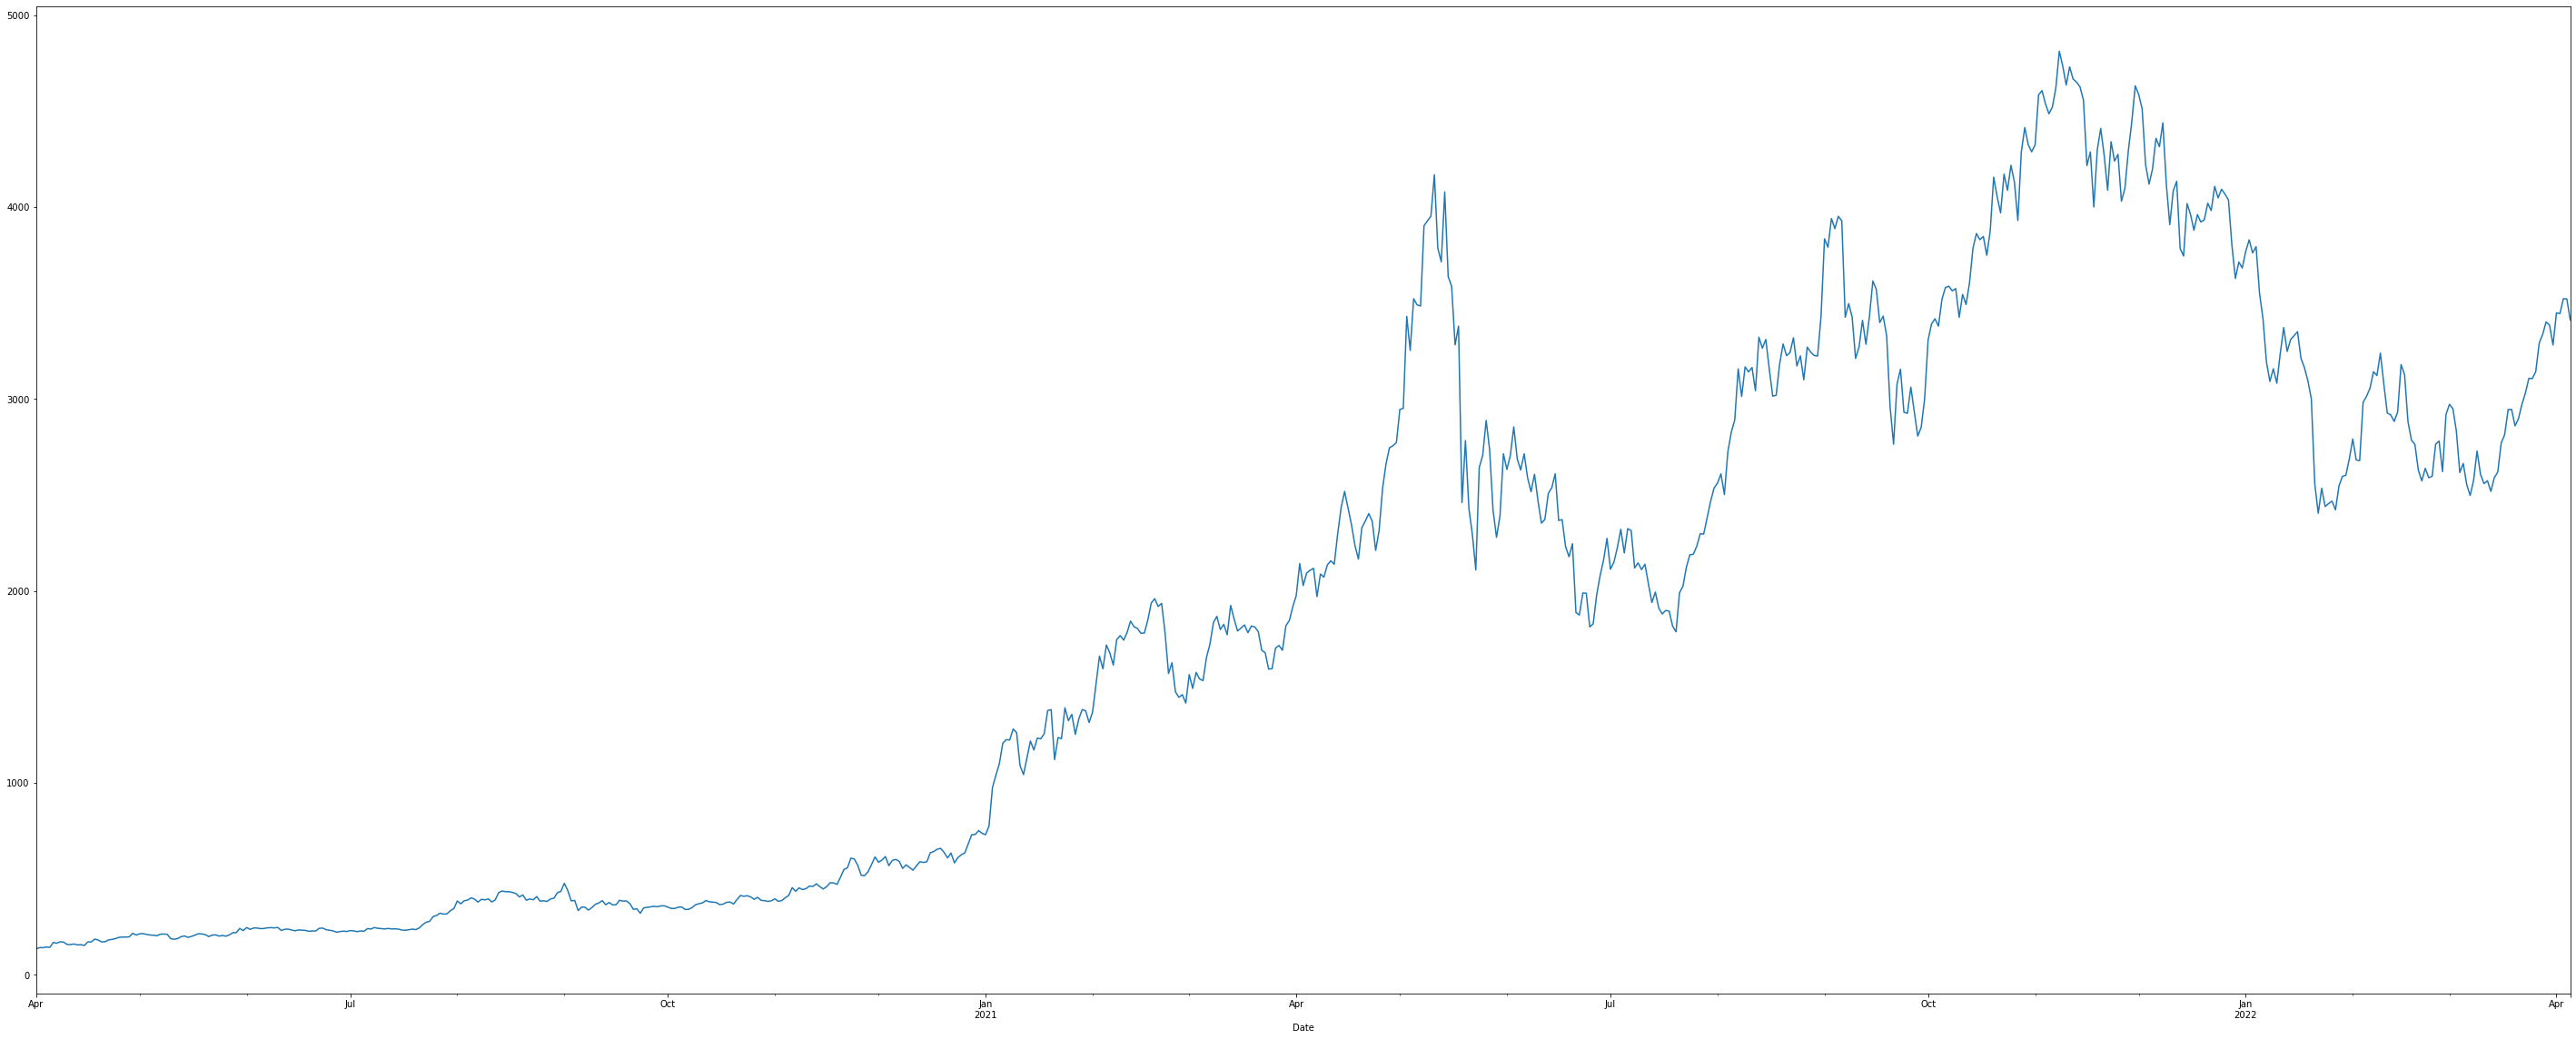

In [4]:
# Define target 
y = df.Close
df.Close.plot(figsize=(50, 20))


In [5]:
# Splitting into Train and Test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [6]:
pd.DataFrame(y_test)

,Close
Date,
2021-08-28,3244.403320
2021-08-29,3227.002686
2021-08-30,3224.374268
2021-08-31,3433.732666
2021-09-01,3834.828125
...,...
2022-04-01,3449.552246
2022-04-02,3445.059326
2022-04-03,3522.833496


  ### Choose best learning rate and max depth using hyper parameter tuning

In [7]:
%%capture
from hpbandster_sklearn import HpBandSterSearchCV

param_distributions = {"max_depth": list(range(1, 10)), "learning_rate":[0,0.25,.5,.75,1],"max_features":[0,1,2,3]}
model = GradientBoostingRegressor()
search = HpBandSterSearchCV(model, param_distributions,random_state=0, n_jobs=1, n_iter=10, verbose=1).fit(X_train_scaled, y_train.ravel())
search.best_params_



  ### Create Gradient Boosting Regressor

In [8]:
# Choose a learning rate and create classifier
gradientBoostingRegressor = GradientBoostingRegressor(
    n_estimators=27,
    learning_rate = search.best_params_['learning_rate'],
    max_depth = search.best_params_['max_depth'],
    max_features=search.best_params_['max_features'],
    random_state=0
)

# Fit the model
gradientBoostingRegressor.fit(X_train_scaled, y_train.ravel())

# Make Prediction
predictions = gradientBoostingRegressor.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(20)

,Prediction,Actual
0,3267.622355,3244.403320
1,3206.090253,3227.002686
2,3191.778460,3224.374268
3,3485.426732,3433.732666
4,3689.279751,3834.828125
5,3789.975303,3790.989990
6,3950.036880,3940.614746
7,3906.930000,3887.828369
8,4064.507572,3952.133545
9,3990.470370,3928.379395


  ### Evaluate the model

In [9]:
# Calculating the accuracy score
# acc_score = accuracy_score(y_test, predictions)
# print(f"Accuracy Score : {acc_score}")


stocks = pd.DataFrame({
    "Real": y_test.ravel(),
    "Predicted": predictions.ravel()
    }, index = df.index[-len(y_test): ])
stocks.head(100)



,Real,Predicted
Date,,
2021-08-28,3244.403320,3267.622355
2021-08-29,3227.002686,3206.090253
2021-08-30,3224.374268,3191.778460
2021-08-31,3433.732666,3485.426732
2021-09-01,3834.828125,3689.279751
...,...,...
2021-12-01,4586.990234,4032.624987
2021-12-02,4511.302246,4168.369394
2021-12-03,4220.706055,3969.015414


<AxesSubplot:xlabel='Date'>

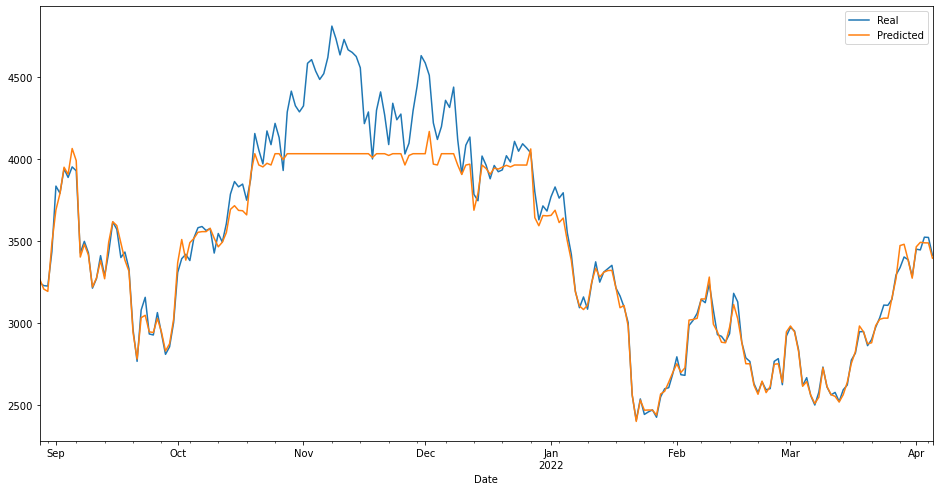

In [12]:
plt=stocks.plot(figsize = (16,8))
plt.get_figure().savefig("image/GradientBoosting.png")
plt

In [11]:

print(f'Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predictions), 4))
print(f'Mean Squared Error:', round(metrics.mean_squared_error(y_test, predictions), 4))
print(f'Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 4))
print(f'(R^2) Score:', round(metrics.r2_score(y_test, predictions), 4))
errors = abs(predictions - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 106.6018
Mean Squared Error: 37398.4523
Root Mean Squared Error: 193.3868
(R^2) Score: 0.9069
Accuracy: 97.42 %.
